# IMPORTATION

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error,f1_score, precision_score, recall_score
import torch 
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, Trainer, TrainingArguments, BertForSequenceClassification,BertTokenizer
import re
import evaluate

# LOAD DATA

In [2]:
data = pd.read_csv(r"C:\Users\avina\OneDrive\Desktop\Movie review prediction\IMDB Dataset.csv")

# DATA SHAPE 

In [3]:
data = data.sample(n=2000, random_state=42).reset_index(drop=True)

In [4]:
data.shape

(2000, 2)

In [5]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [6]:
data['sentiment'].value_counts()

sentiment
negative    1024
positive     976
Name: count, dtype: int64

# CLEANING DATA

In [7]:
data = data.dropna()

In [8]:
def data_clean(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)  
    text = re.sub(r'\bbr\b', ' ', text, flags=re.IGNORECASE)
    return re.sub(r'\s+', ' ', text).strip()

data['review'] = data['review'].apply(data_clean)

print(data[['review']].head())


                                              review
0  I really liked this Summerslam due to the look...
1  Not many television shows appeal to quite as m...
2  The film quickly gets to a major chase scene w...
3  Jane Austen would definitely approve of this o...
4  Expectations were somewhat high for me when I ...


# LABELING THE SENTIMENT

In [9]:
label = {'positive':1, 'negative':0,}
data['label'] = data['sentiment'].map(label)

 ***LABLE X and Y***

In [10]:
X = data['review']
Y = data['label']

# Train Test split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=32,stratify=Y) 

# TOKENIZATION

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [13]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=120):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
    
        if pd.isna(label):
            label = 0 
    
        label = int(label)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
    
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [14]:
train_dataset = IMDBDataset(X_train, Y_train, tokenizer)
test_dataset = IMDBDataset(X_test, Y_test, tokenizer)

In [15]:

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 - # Funtion for metric Prediction (accuracy, f1-score, confusion matrix)

In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    cm = confusion_matrix(labels, predictions)
    print("Confusion Matrix:\n", cm)
    return {'accuracy': acc, 'f1': f1}

In [18]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",  
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

C:\Users\avina\AppData\Local\Temp\ipykernel_21108\407658018.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

C:\Users\avina\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.508000,0.341445,0.862500,0.862491
2,0.455700,0.521024,0.862500,0.861937
3,0.146400,0.762350,0.837500,0.837460


Confusion Matrix:
 [[178  27]
 [ 28 167]]


C:\Users\avina\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix:
 [[188  17]
 [ 38 157]]


C:\Users\avina\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix:
 [[166  39]
 [ 26 169]]


TrainOutput(global_step=600, training_loss=0.3172720704724391, metrics={'train_runtime': 5487.0134, 'train_samples_per_second': 0.875, 'train_steps_per_second': 0.109, 'total_flos': 295999937280000.0, 'train_loss': 0.3172720704724391, 'epoch': 3.0})

# Train Evaluate

In [21]:

results = trainer.evaluate()

print("Transformer Model Performance:", results)

C:\Users\avina\anaconda\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix:
 [[178  27]
 [ 28 167]]
Transformer Model Performance: {'eval_loss': 0.3414453864097595, 'eval_accuracy': 0.8625, 'eval_f1': 0.8624905397206638, 'eval_runtime': 69.7457, 'eval_samples_per_second': 5.735, 'eval_steps_per_second': 0.717, 'epoch': 3.0}


# logistic regression on TF-IDF features

In [32]:
X = data['review']
y = data['sentiment']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:

Tfidf = TfidfVectorizer()
X_train_tfidf = Tfidf.fit_transform(X_train)
X_test_tfidf = Tfidf.fit_transform(X_train)
X_test_tfidf = 

base_model = LogisticRegression()
base_model.fit(X_train_tfidf,Y_train)

y_base_model  = base_model.predict(X_test_tfidf)


- # CLASSIFICATION REPORT

In [63]:
print(classification_report(Y_test, y_base_model))
cm_baseline = confusion_matrix(Y_test, y_base_model)

              precision    recall  f1-score   support

    negative       0.67      0.90      0.77        50
    positive       0.85      0.56      0.67        50

    accuracy                           0.73       100
   macro avg       0.76      0.73      0.72       100
weighted avg       0.76      0.73      0.72       100



# Actual vs Predicted

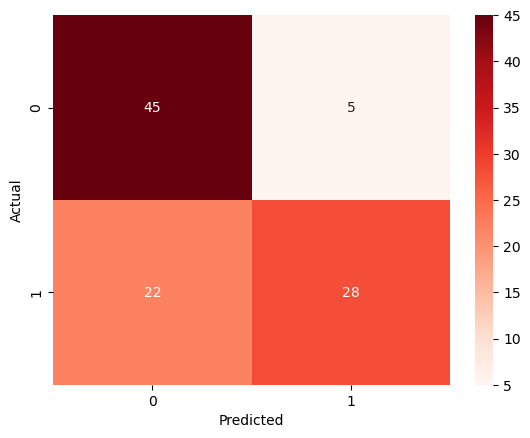

In [66]:
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Saving the Fine tunned model 

In [22]:
model_path = "./sentiment_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model and tokenizer saved to {model_path}")


loaded_tokenizer = BertTokenizer.from_pretrained(model_path)
loaded_model = BertForSequenceClassification.from_pretrained(model_path)
loaded_model.eval()

Model and tokenizer saved to ./sentiment_model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# predicting the sentiment

In [ ]:
def predict_sentiment(text):
    inputs = loaded_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = loaded_model(**inputs)
    
    probs = torch.softmax(outputs.logits, dim=1)
    print(f"Prediction probabilities: Negative {probs[0][0]:.2f}, Positive {probs[0][1]:.2f}") 
    
    pred_label = torch.argmax(probs, dim=1).item()
    sentiment = "Positive" if pred_label == 1 else "Negative"
    return sentiment


while True:
    review = input("Enter a movie review (or 'quit' to exit): ")
    if review.lower() == "quit":
        break
    result = predict_sentiment(review)
    print(f"Sentiment: {result}")


Enter a movie review (or 'quit' to exit):  the movie was worst


Prediction probabilities: Negative 0.92, Positive 0.08
Sentiment: Negative


Enter a movie review (or 'quit' to exit):  the movie was good


Prediction probabilities: Negative 0.29, Positive 0.71
Sentiment: Positive


Enter a movie review (or 'quit' to exit):  i like  the movie


Prediction probabilities: Negative 0.37, Positive 0.63
Sentiment: Positive


Enter a movie review (or 'quit' to exit):  content of the movie is good


Prediction probabilities: Negative 0.16, Positive 0.84
Sentiment: Positive
